# Audio Diary for Wellness Tracking

A capstone project as part of the Samsung Innovation Campus AI Course, that focuses on Audio Transcription, Speech Recognition, Natual Language Processing (NLP) and GPT2 Modeling. 
The aim of this project is to use audio input from users and identify the symptopms they are likely facing.

Credits:
 Adel Yousefi,
 Arnaz Nushrah,
 Mohamed Gamal,
 Yahya Ali,
 Zahra Alkhoori,

In [ ]:
!pip install kaggle -q

! mkdir .kaggle

#kaggle.json is the api key for your account
! cp "kaggle.json" .kaggle
! chmod 600 ~/.kaggle/kaggle.json

# Downloading medical-speech-transcription dataset
!kaggle datasets download -d paultimothymooney/medical-speech-transcription-and-intent

!unzip -q "medical-speech-transcription-and-intent" 

# IMPORTS

In [27]:
!pip install huggingsound
!pip install transformers

In [83]:
import os
import IPython
import numpy as np
import pandas as pd
import huggingsound
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from huggingsound import SpeechRecognitionModel

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import torch
from torch.utils.data import TensorDataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments

# EXPLORATORY DATA ANALYSIS

In [13]:
df=pd.read_csv("medical speech transcription and intent/Medical Speech, Transcription, and Intent/overview-of-recordings.csv")

In [14]:
df.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_43453425_58166571.wav&key=test_key_TISTK,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_43719934_43347848.wav&key=test_key_TISTK,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking my back,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_43719934_53187202.wav&key=test_key_TISTK,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_31349958_55816195.wav&key=test_key_TISTK,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen and the skin inside on his lip is grey and looks infected.,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_43719934_82524191.wav&key=test_key_TISTK,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                        6661 non-null   object 
 6   quiet_speaker:confidence             6661 non-null   float64
 7   speaker_id                           6661 non-null   int64  
 8   file_download                        6661 non-null   object 
 9   file_name                            6661 non-null   object 
 10  phrase                               6661 non-null   object 
 11  prompt                        

In [33]:
df.describe(include = 'object').transpose()

,count,unique,top,freq
audio_clipping,6661,2,no_clipping,6607
background_noise_audible,6661,2,no_noise,3523
quiet_speaker,6661,2,audible_speaker,6646
file_download,6661,6661,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?download=1249120_28006404_51635944.wav&key=test_key_TISTK,1
file_name,6661,6661,1249120_44263136_49038863.wav,1
phrase,6661,706,When I stand up too quickly I start to feel dizzy and light-headed,35
prompt,6661,25,Acne,328


In [85]:
print("Checking count of unique phrases for each prompt: ")
df.groupby('prompt')['phrase'].nunique()

Checking count of unique phrases for each prompt: 


prompt
Acne                  34
Back pain             27
Blurry vision         26
Body feels weak       26
Cough                 31
Ear ache              28
Emotional pain        24
Feeling cold          27
Feeling dizzy         26
Foot ache             27
Hair falling out      28
Hard to breath        25
Head ache             27
Heart hurts           31
Infected wound        34
Injury from sports    27
Internal pain         26
Joint pain            34
Knee pain             32
Muscle pain           29
Neck pain             25
Open wound            22
Shoulder pain         35
Skin issue            29
Stomach ache          27
Name: phrase, dtype: int64

In [17]:
print("Length of Testing Data:",len(os.listdir("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test")))
print("Length of Training Data:",len(os.listdir("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train")))
print("Length of Validation Data:",len(os.listdir("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/validate")))

Length of Testing Data: 381
Length of Training Data: 5895
Length of Validation Data: 385


In [20]:
# Assuming 'df' is your dataframe and 'target_col' is the column containing your target variable
X = df.drop(columns=['prompt'])
y = df['prompt']

# Split the data into a training set (80%) and a test set (20%), with stratification on the target variable
train_df, test_df, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.concat([train_df, train_y], axis=1)
test_df=pd.concat([test_df, test_y], axis=1)

The folders are not named correctly as the test folder has the most number of records, which should be the trainingset. Hence, the next step is to rename these folders correctly.

In [ ]:
# Change the folders name as follows:
# test >>>> train
# train >>> test
import os
os.rename("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test","medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train")
os.rename("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train","medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test")

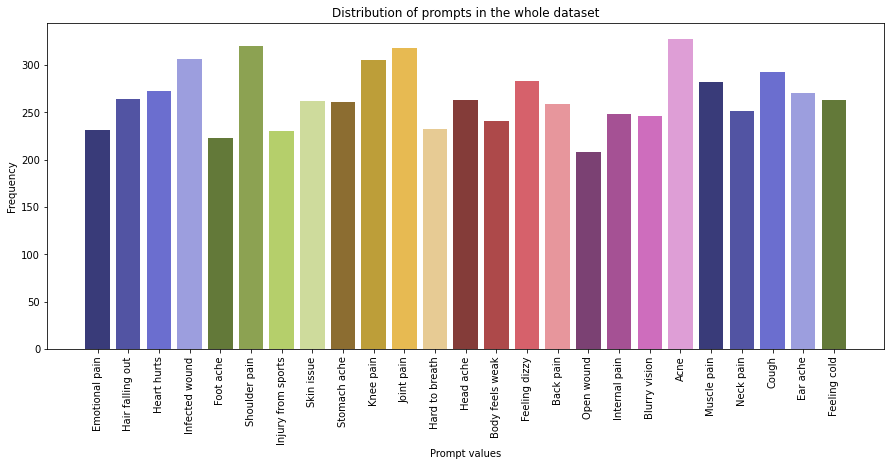

In [25]:
cat_values=df['prompt'].unique().tolist()
# Generate a list of 25 colors from a Seaborn color palette
colors = sns.color_palette('tab20b', n_colors=25)

# Convert the 'prompt' column to a categorical type, with the specified order
data= df['prompt'].value_counts().loc[cat_values]

# Create the plot
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)

# Set a different color for each bin
plt.bar(data.index,data,color=colors)

plt.title('Distribution of prompts in the whole dataset')
plt.xlabel('Prompt values')
plt.ylabel('Frequency')
plt.show()

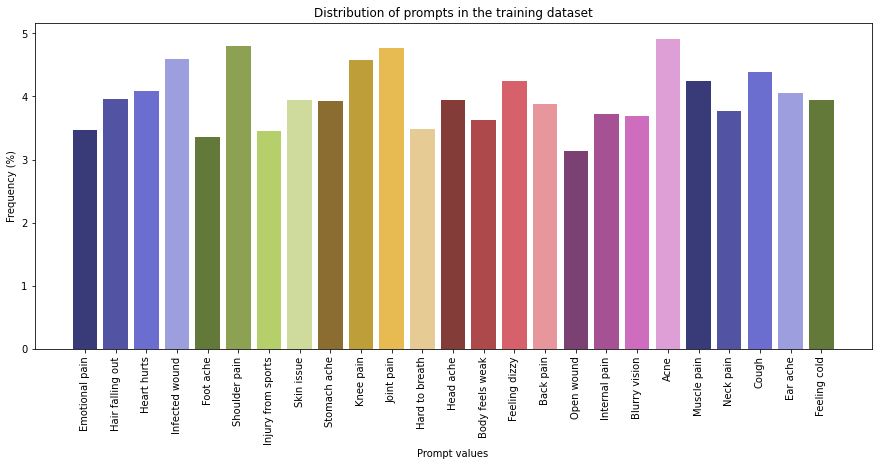

In [23]:
# Convert the 'prompt' column to a categorical type, with the specified order
data= train_y.value_counts().loc[cat_values]/len(train_y) *100

# Create the plot
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)

# Set a different color for each bin
plt.bar(data.index,data,color=colors)

plt.title('Distribution of prompts in the training dataset')
plt.xlabel('Prompt values')
plt.ylabel('Frequency (%)')
plt.show()

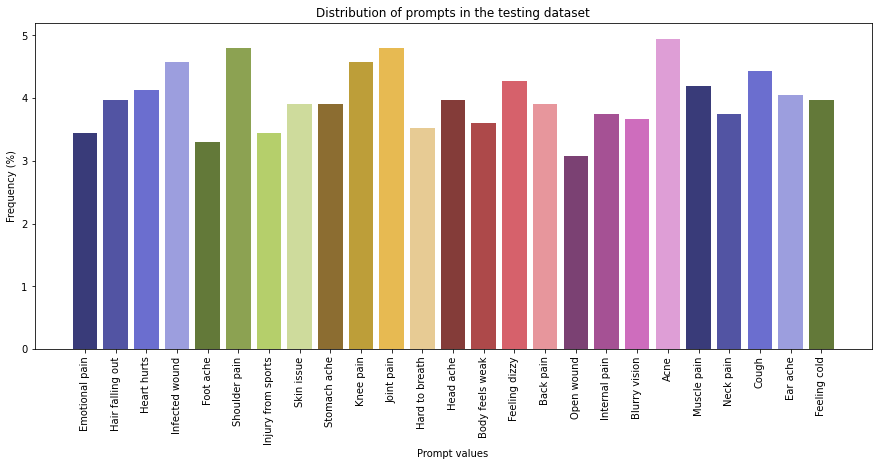

In [26]:
# Convert the 'prompt' column to a categorical type, with the specified order
data= test_y.value_counts().loc[cat_values] /len(test_y) *100

# Create the plot
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)

# Set a different color for each bin
plt.bar(data.index,data,color=colors)

plt.title('Distribution of prompts in the testing dataset')
plt.xlabel('Prompt values')
plt.ylabel('Frequency (%)')
plt.show()

# TRANSCRIPTION

In [34]:
model = SpeechRecognitionModel("jonatasgrosman/wav2vec2-large-xlsr-53-english")

03/28/2023 01:19:33 - INFO - huggingsound.speech_recognition.model - Loading model...


In [40]:
num = 2000
audio_paths = []
train_data = os.listdir("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train")
for x in range(len(train_data[:num])):
  audio_paths.append(os.path.join("medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/train",train_data[x]))

transcriptions = model.transcribe(audio_paths)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [53:15<00:00,  1.60s/it]


In [52]:
generated=[]
ground_truth=[]
for x in range(len(transcriptions)):
  phrase=df.loc[df.file_name==train_data[x],"phrase"].values[0]
  ground_truth.append(phrase.strip("."))
  generated.append(transcriptions[x]['transcription'])

In [53]:
def wer(truth_list, hypothesis_list):
    """
    Calculate Word Error Rate (WER) between ground truth and hypothesis
    for a list of text inputs
    """
    total_wer = 0.0
    num_samples = len(truth_list)

    for i in range(num_samples):
        truth = truth_list[i]
        hypothesis = hypothesis_list[i]
        
        # split the ground truth and hypothesis into words
        truth_words = truth.split()
        hypothesis_words = hypothesis.split()
        
        # calculate the Levenshtein distance between the words
        # using dynamic programming
        D = {}
        n = len(truth_words)
        m = len(hypothesis_words)
        
        for i in range(n + 1):
            D[i, 0] = i
        for j in range(m + 1):
            D[0, j] = j
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                if truth_words[i - 1] == hypothesis_words[j - 1]:
                    D[i, j] = D[i - 1, j - 1]
                else:
                    D[i, j] = min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]) + 1
        
        # calculate the WER for this sample
        sample_wer = D[n, m] / n
        total_wer += sample_wer
    
    # calculate the average WER across all samples
    average_wer = total_wer / num_samples
    
    return average_wer

In [54]:
wer(ground_truth,generated)

0.29694302795094674

In [55]:
# Compare ground truth and generated
for ground_truth, generated in zip(ground_truth, generated):
    print("Ground:   ",ground_truth)
    print("Generated:  ",generated)
    print("#"*50)

Ground:    I have a painful cramp in my feet
Generated:   i have a painful cramp in my feet
##################################################
Ground:    The pain feels like it's right below the skin
Generated:   the pain feels like is righp by low to skin
##################################################
Ground:    I feel suicidal
Generated:   i feel suicidal
##################################################
Ground:    I feel a sharp pain in my ankle joint when I stand
Generated:   i feel a sharp pain in my ankle joint when i stand
##################################################
Ground:    My shoulder hurts me so much
Generated:   my shoulder hurts me so much
##################################################
Ground:    I have a hair shortage
Generated:   i have a hair shortage
##################################################
Ground:    My left ear is ok, but the right one feels like it's being stabbed with a nail
Generated:   my love air is ok but the right one feels like it i

# GPT2 MODEL

In [56]:
# Load the dataset
to_tekonize = train_df

# Assign integer indices to the string labels
label_map = {'Emotional pain':0,
             'Hair falling out':1,
             'Heart hurts':2,
             'Infected wound':3,
             'Foot ache':4,
             'Shoulder pain':5,
             'Injury from sports':6,
             'Skin issue':7,
             'Stomach ache':8,
             'Knee pain':9,
             'Joint pain':10,
             'Hard to breath':11,
             'Head ache':12,
             'Body feels weak':13,
             'Feeling dizzy':14,
             'Back pain':15,
             'Open wound':16,
             'Internal pain':17,
             'Blurry vision':18,
             'Acne':19,
             'Muscle pain':20,
             'Neck pain':21,
             'Cough':22,
             'Ear ache':23,
             'Feeling cold':24}
 
to_tekonize['label_id'] = to_tekonize['prompt'].apply(lambda x: label_map[x])

# Initialize the GPT2 tokenizer and add a padding token
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the texts and pad to a maximum length
max_length = max([len(text) for text in to_tekonize['phrase']])
tokenized_texts = [tokenizer(text, truncation=True, padding='max_length', max_length=max_length) for text in to_tekonize['phrase']]

In [61]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [73]:
def collate_fn(batch):
    input_ids_batch = torch.stack([item[0] for item in batch]).cpu()
    attention_mask_batch = torch.stack([item[1] for item in batch]).cpu()
    labels_batch = torch.stack([item[2] for item in batch]).cpu()
    
    return {'input_ids': input_ids_batch, 'attention_mask': attention_mask_batch, 'labels': labels_batch}

In [79]:
# Create the input tensors
input_ids = torch.tensor([text['input_ids'] for text in tokenized_texts])
attention_mask = torch.tensor([text['attention_mask'] for text in tokenized_texts])
labels = torch.tensor(to_tekonize['label_id'].tolist())

In [65]:
# Define the GPT2 model for sequence classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=25).to(device)
model.config.pad_token_id = model.config.eos_token_id

# Define the training arguments
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    metric_for_best_model='accuracy',
    learning_rate=0.0001
    )

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
# Convert labels to numpy array
L_int = np.array(labels.cpu())

train_dataset=TensorDataset(input_ids, attention_mask, labels)

# Create a StratifiedShuffleSplit object
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Split the data into train and validation sets while stratifying
train_indices, eval_indices = next(splitter.split(input_ids, L_int))

# Create TensorDatasets for train and validation sets
train_dataset = torch.utils.data.TensorDataset(input_ids[train_indices], attention_mask[train_indices], labels[train_indices])
eval_dataset = torch.utils.data.TensorDataset(input_ids[eval_indices], attention_mask[eval_indices], labels[eval_indices])

In [81]:
# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    )

In [84]:
num_epoch=7
losses={"eval_loss":[],"train_loss":[]}
f1score={"train_f1":[],"eval_f1":[]}
Train_labels=[]
for x in range(len(train_dataset)):
  Train_labels.append(int(train_dataset[x][-1].cpu()))


eval_labels=[]
for x in range(len(eval_dataset)):
  eval_labels.append(int(eval_dataset[x][-1].cpu()))



for epoch in range(num_epoch):
  # Train the model

  train_result=trainer.train()
  
  predictions = trainer.predict(train_dataset).predictions.argmax(axis=-1)
  f1=f1_score(Train_labels, predictions, average='weighted')

  losses['train_loss'].append(train_result[1])
  f1score['train_f1'].append(f1)
  # Evaluate the model on the test set
  eval_result = trainer.evaluate(eval_dataset=eval_dataset)
  
  predictions = trainer.predict(eval_dataset).predictions.argmax(axis=-1)
  f1=f1_score(eval_labels, predictions, average='weighted')
  
  losses['eval_loss'].append(eval_result['eval_loss'])
  f1score['eval_f1'].append(f1)

Step,Training Loss
500,1.635200


Step,Training Loss
500,1.630500


Step,Training Loss
500,1.588400


Step,Training Loss
500,1.610300


Step,Training Loss
500,1.631400


Step,Training Loss
500,1.622200


Step,Training Loss
500,1.624900


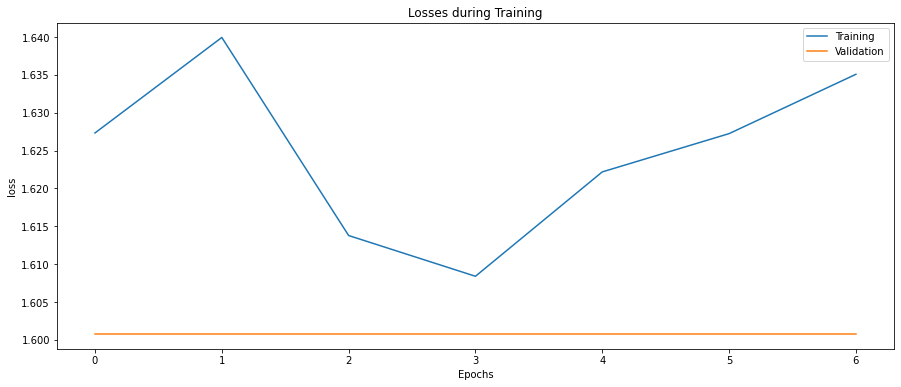

In [86]:
plt.figure(figsize=(15,6))
plt.plot(losses['train_loss'])
plt.plot(losses['eval_loss'])

plt.title('Losses during Training')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['Training',"Validation"])
plt.show()

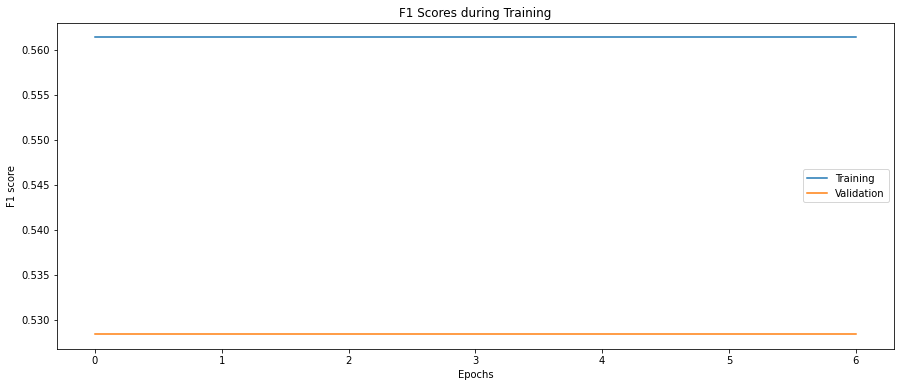

In [87]:
plt.figure(figsize=(15,6))
t=f1score['train_f1']
e=f1score['eval_f1']
plt.plot(t)
plt.plot(e)

plt.title('F1 Scores during Training')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend(['Training',"Validation"])
plt.show()

# TESTING

In [88]:
test_ids = test_df['prompt'].apply(lambda x: label_map[x])

# Tokenize the texts and pad to a maximum length
tokenized_texts = [tokenizer(text, truncation=True, padding='max_length', max_length=max_length) for text in test_df['phrase']]

# Create the input tensors
#TF_IDF
input_ids = torch.tensor([text['input_ids'] for text in tokenized_texts]).to(device)
attention_mask = torch.tensor([text['attention_mask'] for text in tokenized_texts]).to(device)
labels = torch.tensor(test_ids.tolist()).to(device)

test_dataset=TensorDataset(input_ids, attention_mask, labels)

In [89]:
True_value=[]
for x in range(len(test_dataset)):
  True_value.append(int(test_dataset[x][-1].cpu()))

# Get the predicted labels
predictions = trainer.predict(test_dataset).predictions.argmax(axis=-1)

# Get the true labels
true_labels = True_value

# Print the classification report
target_names = label_map.keys()
print(classification_report(true_labels, predictions, target_names=target_names))

                    precision    recall  f1-score   support

    Emotional pain       0.30      0.07      0.11        46
  Hair falling out       0.95      0.79      0.87        53
       Heart hurts       0.21      0.89      0.34        55
    Infected wound       0.70      0.74      0.72        61
         Foot ache       0.79      0.77      0.78        44
     Shoulder pain       0.69      0.62      0.66        64
Injury from sports       1.00      0.13      0.23        46
        Skin issue       0.65      0.67      0.66        52
      Stomach ache       0.59      0.75      0.66        52
         Knee pain       0.82      0.66      0.73        61
        Joint pain       0.52      0.48      0.50        64
    Hard to breath       0.00      0.00      0.00        47
         Head ache       0.19      0.17      0.18        53
   Body feels weak       0.62      0.38      0.47        48
     Feeling dizzy       0.51      0.81      0.63        57
         Back pain       0.65      0.54

<AxesSubplot:>

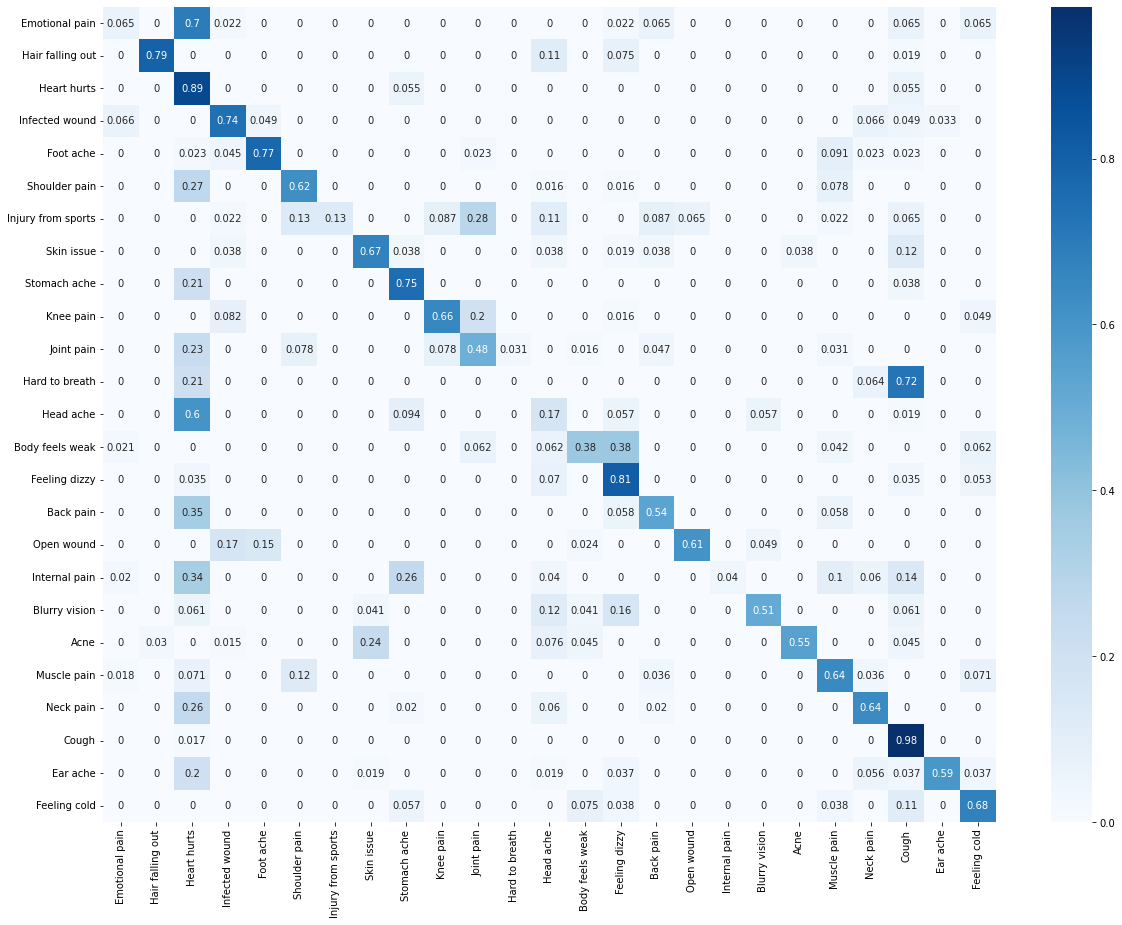

In [90]:
# Get the predicted labels
#predictions = trainer.predict(test_dataset).predictions.argmax(axis=-1)
plt.figure(figsize=(20,15))
# Get the true labels
true_labels = True_value

# Get the class labels
class_labels = list(label_map.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)